In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
                     'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'ytick.major.size'  : 4,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'sans-serif',
                     'figure.figsize': (15/3, 3.3),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.25
                    })
sns.set_palette('deep')

In [5]:
import new

In [6]:
from utils import *
from dataloader import *
import jax.numpy as jnp
import jax, jax.random as random
from inference import infer_inputs

In [7]:
# jax.config.update("jax_default_matmul_precision", "high")
# import os
# os.environ['XLA_FLAGS'] = (
#     '--xla_gpu_triton_gemm_any=True '
#     '--xla_gpu_enable_latency_hiding_scheduler=true ')

In [8]:
X = pd.read_csv('../data/rsp.bettergridsetc/features.dat', sep=r'\s+')
y = jnp.load('../data/rsp.bettergridsetc/targets.npy')
features = ['RSP_Z','RSP_X','RSP_mass','RSP_L','RSP_Teff','RSP_alfa']
X = jnp.array(X[features].values)
key1, key2 = random.split(random.PRNGKey(42))
X_train, y_train, X_test, y_test = train_test_split(key1, X, y, split=0.2, shuffle=False)
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0)
std_y = y_train.std()
y_train = y_train/std_y
y_test = y_test/std_y
X_train = (X_train - mu)/sd
X_test = (X_test - mu)/sd
input_dim  = X_train.shape[1]
output_dim = y_train.shape[1]

In [9]:
model = new.ImprovedTransformer(model_dim=256,ff_dim=512)
s = load_model('new_arch_res')
from functools import partial
body_fn = jax.jit(partial(model.apply, s['state']['params']))

/home/sk3365/.conda/envs/gpujax/lib/python3.13/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


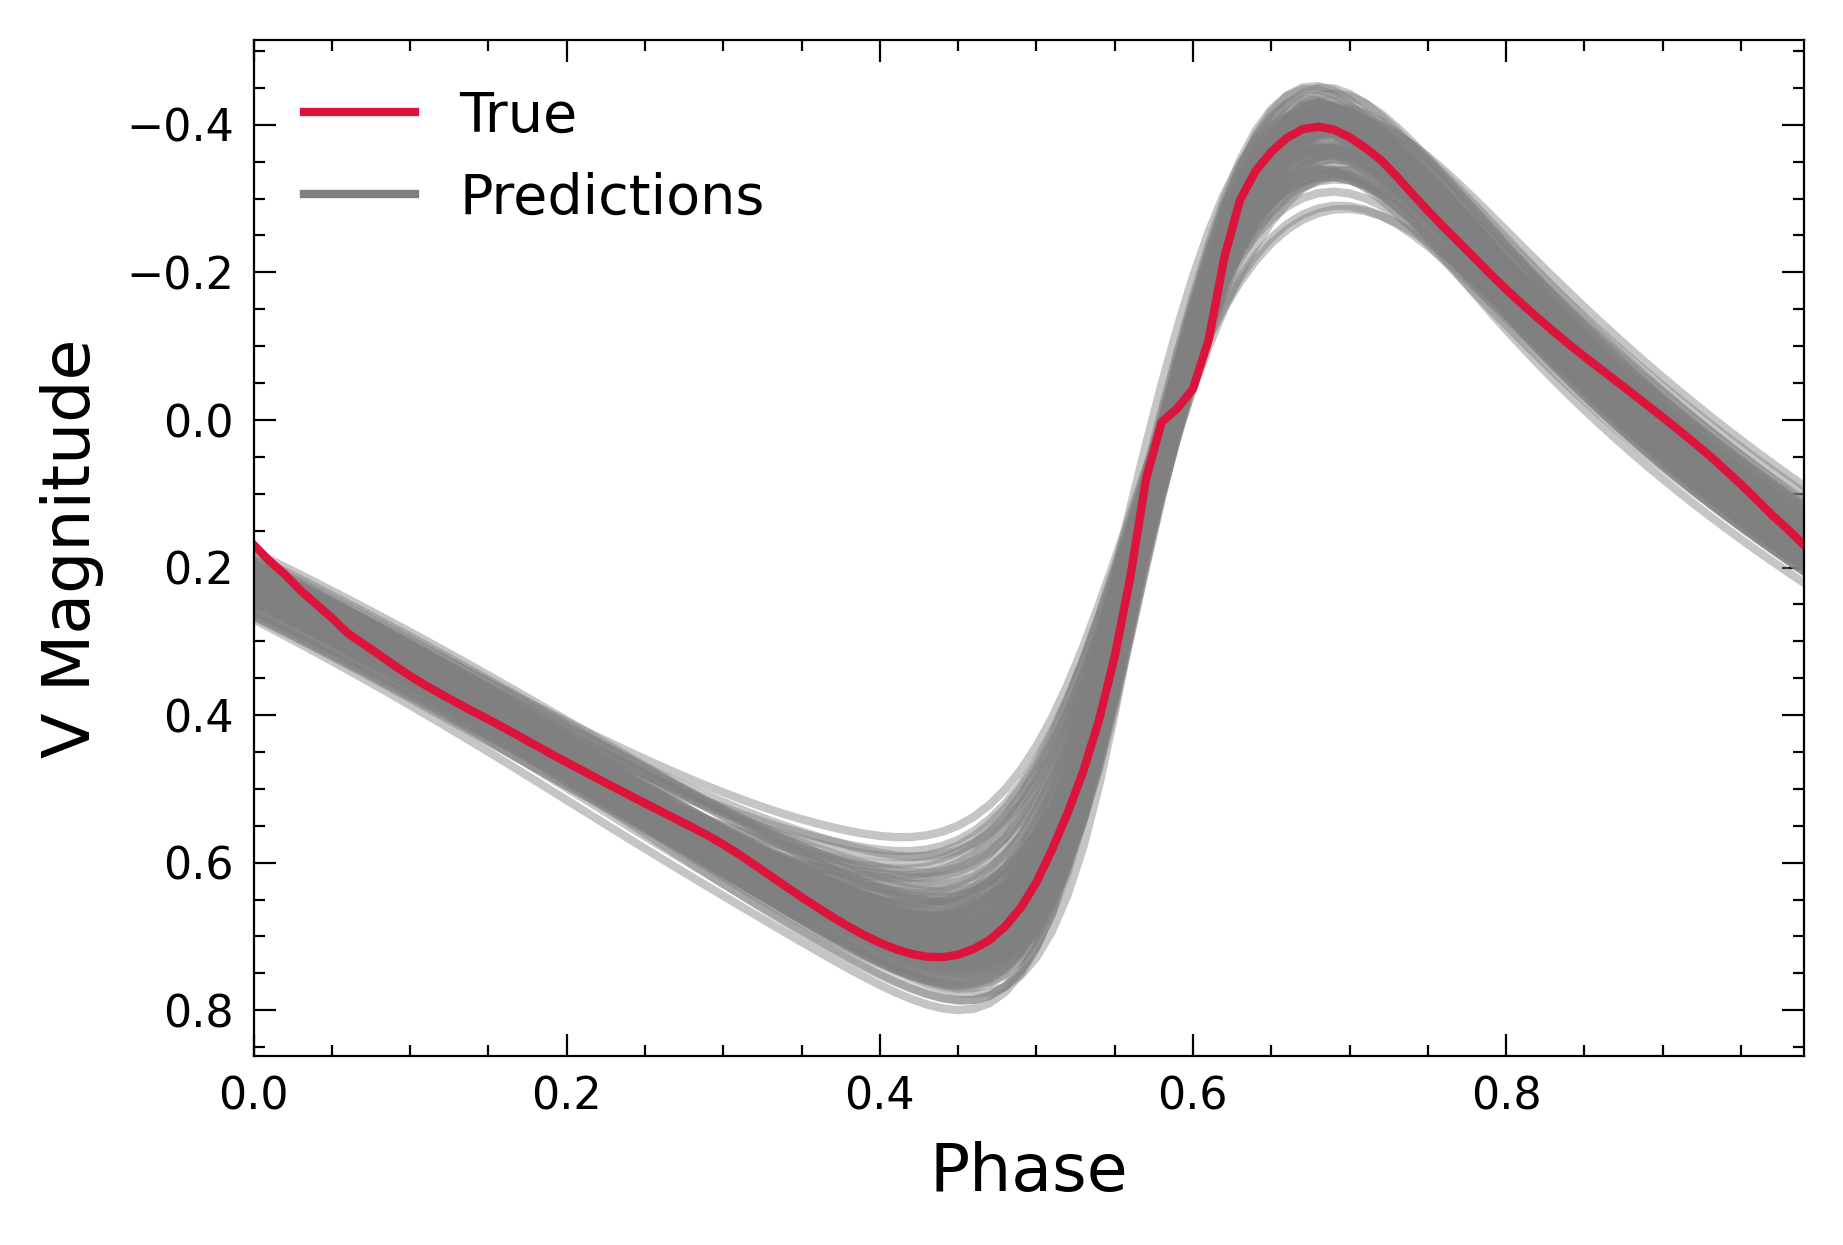

In [30]:
mod = 14 
y_pred = body_fn(X_train[mod].reshape(-1,6))
@jax.jit
def loss_fn(X):
    pred = body_fn(X.reshape(1,-1)).squeeze()
    return jnp.mean((pred - y_train[mod])**2)
X_init = jax.scipy.optimize.minimize(
        loss_fn, jnp.zeros(6), method='BFGS').x
x = X_init.reshape(-1,6)
x = jnp.repeat(x, 100, axis=0)
x = x + 5e-2*random.normal(random.key(11),shape=(x.shape))
y_preds = body_fn(x)
y_preds.shape
phase = jnp.arange(100)/100
for pred in y_preds:
	plt.plot(phase, pred*std_y, alpha=0.45, c='grey')
# plt.plot(phase, body_fn(jnp.array([-0.05949636, -0.83456725, -2.2712946 ,  0.01797971,  1.4692581 ]).reshape(1,5)).flatten(), c='red')
plt.plot(phase, y_train[mod]*std_y, c='crimson', label='True')
plt.plot([], [], c='grey', label='Predictions')
plt.xlim(0,0.99)
plt.gca().invert_yaxis()
plt.ylabel('V Magnitude', fontsize=12)
plt.xlabel('Phase', fontsize=12)
plt.legend(frameon=False)
plt.savefig('nice-example.pdf', bbox_inches='tight')

# Hamiltonian Monte Carlo

In [98]:
from numpyro.infer import MCMC, NUTS, init_to_median
from numpyro.infer.initialization import init_to_value
import numpyro.distributions as dist
import numpyro

In [100]:
def loss_fn(X, y=None):
    pred = body_fn(X.reshape(1,-1)).squeeze()
    return jnp.mean((pred - y)**2)

X_init = jax.scipy.optimize.minimize(
    partial(loss_fn, y=y_test[100]), jnp.zeros(6), method='BFGS').x
init_params = {'features': X_init}

def model(y_obs):
	with numpyro.plate('f', 1):
	    X = numpyro.sample("features",
						   dist.ImproperUniform(dist.constraints.interval(-3,3),
											   event_shape=(6,), batch_shape=(1,)))
		
	pred = body_fn(X.reshape(1,-1)).squeeze()
	noise_scale = numpyro.sample("noise", dist.HalfNormal(0.01))
	numpyro.sample(
        "obs",
        dist.Normal(pred, noise_scale),
        obs=y_test
    )

In [101]:
num_warmup=2500
num_samples=500
nuts_kernel = NUTS(
    model,
    adapt_step_size=True,
    adapt_mass_matrix=True,
	init_strategy=init_to_value(values=init_params),
    target_accept_prob=0.99,
    max_tree_depth=12
)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
)

In [ ]:
key = random.key(42)
mcmc.run(
    rng_key=key,
    y_obs=y_test[100],
)

warmup:   3%|▎         | 89/3000 [00:15<15:03,  3.22it/s, 607 steps of size 2.81e-03. acc. prob=0.94]

In [ ]:
mcmc.print_summary()

In [ ]:
mcmc.get_samples()['features'].mean(axis=0), X_test[100], x[0]

# SVI

In [41]:
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import optax

In [45]:
num_steps = 100000
learning_rate = 5e-4

In [46]:
optimizer = optax.adamw(learning_rate)
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
rng_key = random.key(42)
svi_result = svi.run(rng_key, num_steps, y_test[100], init_params=init_params)

params = svi_result.params
losses = svi_result.losses

100%|██████████| 100000/100000 [01:54<00:00, 870.34it/s, init loss: 3168764.0000, avg. loss [95001-100000]: 41137.2461]


In [91]:
params

{'auto_loc': Array([-0.06594701, -0.8795046 , -2.283314  , -0.00282233,  1.2653651 ,
        -0.92738193], dtype=float32)}